In [1]:
import os
import json
import pandas as pd
from datetime import datetime
import numpy as np
import torch
import torch.nn as nn
from torchvision.utils import make_grid

import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import argparse

import sys 
sys.path.append(os.path.abspath('../'))
import modules.noise_generator

# Parameters & Functions

In [2]:
def extract_wandb_data(wandb_dir, start_time_str, end_time_str):
    """
    Extracts WandB run data between the specified time range and returns a DataFrame.

    Parameters:
    - wandb_dir (str): Directory where all runs are stored.
    - start_time_str (str): Start time as a string in the format 'YYYYMMDD_HHmmSS'.
    - end_time_str (str): End time as a string in the format 'YYYYMMDD_HHmmSS'.

    Returns:
    - pd.DataFrame: DataFrame containing the runs data within the time range.
    """

    # Convert timestamp strings to datetime objects
    start_time = datetime.strptime(start_time_str, "%Y%m%d_%H%M%S")
    end_time = datetime.strptime(end_time_str, "%Y%m%d_%H%M%S")

    # List to store data
    data = []

    # Loop through all subdirectories
    for subdir in os.listdir(wandb_dir):
        subdir_path = os.path.join(wandb_dir, subdir)

        if os.path.isdir(subdir_path) and subdir.startswith('run-'):
            # Extract timestamp from the directory name
            timestamp_str = subdir.split('-')[1]
            timestamp = datetime.strptime(timestamp_str[:15], "%Y%m%d_%H%M%S")

            # Filter by the given timestamp range
            if start_time <= timestamp <= end_time:
                # Load the wandb-summary.json and wandb-metadata.json files
                summary_path = os.path.join(subdir_path, 'files', 'wandb-summary.json')
                metadata_path = os.path.join(subdir_path, 'files', 'wandb-metadata.json')

                try:
                    with open(summary_path, 'r') as f_summary, open(metadata_path, 'r') as f_metadata:
                        summary_data = json.load(f_summary)
                        metadata_data = json.load(f_metadata)
                        
                        # Extract necessary data
                        run_id = subdir.split('-')[-1]  # Extract id from folder name
                        args = metadata_data.get('args', [])
                        
                        # Convert args to a dictionary format
                        args_dict = {args[i]: args[i+1] for i in range(0, len(args), 2)}

                        # Compile data
                        row = {
                            'timestamp': timestamp,
                            'id': run_id,
                            **summary_data,   # Include all keys from wandb-summary.json
                            **args_dict       # Include all args as columns
                        }
                        
                        # Append row to data list
                        data.append(row)

                except FileNotFoundError as e:
                    print(f"Error loading files for {subdir}: {e}")

    # Create DataFrame from data
    df = pd.DataFrame(data)

    return df

# # Example usage
# wandb_dir = '../BAS/wandb'
# start_time = "20240911_163739"
# end_time = "20250913_030736"

# df = extract_wandb_data(wandb_dir, start_time, end_time)
# df.head()  # Display the first few rows of the DataFrame


In [56]:
# Function to retrieve parameters from the DataFrame
def get_run_parameters(run_id, df):
    run_data = df[df['id'] == run_id]
    if run_data.empty:
        raise ValueError(f"No data found for run ID {run_id}")
    
    # Extract and cast parameters with try-except for default values
    # try:
    #     input_size = int(run_data['--latent_size'].values[0])
    # except (IndexError, ValueError):
    #     input_size = 64

    if '--latent_size' in run_data.columns:
        input_size = int(run_data['--latent_size'].values[0])
    else:
        input_size = 64  # Fallback value if not present

    # try:
    #     hidden_size = int(run_data['--hidden_size'].values[0])
    # except (IndexError, ValueError):
    #     hidden_size = 256

    # try:
    #     image_size = int(run_data['--image_size'].values[0])  # Assuming 'img_dim' is the output size
    # except (IndexError, ValueError):
    #     image_size = 784

    # try:
    #     hidden_layers_g = int(run_data['--hidden_layers_g'].values[0])
    # except (IndexError, ValueError):
    #     hidden_layers_g = 2

    # try:
    #     hidden_layers_d = int(run_data['--hidden_layers_d'].values[0])
    # except (IndexError, ValueError):
    #     hidden_layers_d = 1

    # For hidden_size
    if '--hidden_size' in run_data.columns:
        hidden_size = int(run_data['--hidden_size'].values[0])
    else:
        hidden_size = 256

    # For image_size
    if '--image_size' in run_data.columns:
        image_size = int(run_data['--image_size'].values[0])  # Assuming 'img_dim' is the output size
    else:
        image_size = 784

    # For hidden_layers_g
    if '--hidden_layers_g' in run_data.columns:
        hidden_layers_g = int(run_data['--hidden_layers_g'].values[0])
    else:
        hidden_layers_g = 2

    # For hidden_layers_d
    if '--hidden_layers_d' in run_data.columns:
        hidden_layers_d = int(run_data['--hidden_layers_d'].values[0])
    else:
        hidden_layers_d = 1


     # For hidden_layers_d
    if '--reduction_factor' in run_data.columns:
        reduction_factor = float(run_data['--reduction_factor'].values[0])
    else:
        reduction_factor = 1

    
    return input_size, hidden_size, image_size, hidden_layers_g, hidden_layers_d, reduction_factor

# Define the function to load the models based on run_id
def load_models_by_id(run_id, model_dir='models'):
    # List all files in the model directory
    files = os.listdir(model_dir)
    
    # Find the correct discriminator and generator file based on the run_id
    discriminator_file = next((f for f in files if f.startswith(f"discriminator_{run_id}_") and f.endswith(".pth")), None)
    generator_file = next((f for f in files if f.startswith(f"generator_{run_id}_") and f.endswith(".pth")), None)

    if discriminator_file is None or generator_file is None:
        raise FileNotFoundError(f"Model files for run ID {run_id} not found.")
    
    # Construct full file paths
    discriminator_path = os.path.join(model_dir, discriminator_file)
    generator_path = os.path.join(model_dir, generator_file)
    
    # Load the state_dicts from the saved .pth files
    discriminator_state_dict = torch.load(discriminator_path, weights_only=True)
    generator_state_dict = torch.load(generator_path, weights_only=True)

    return discriminator_state_dict, generator_state_dict

# Define Generator
class Generator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, hidden_layers, reduction_factor):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, input_size)
        self.fc3 = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()

        self.hidden_layers = hidden_layers

    def forward(self, x):
        x = self.relu(self.fc1(x))

        for _ in range(self.hidden_layers):
            x = self.relu(self.fc2(x))
        
        x = self.tanh(self.fc3(x))
        return x

# Define Discriminator
class Discriminator(nn.Module):
    def __init__(self, input_size, hidden_size, hidden_layers, reduction_factor):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, 1)
        self.fc4 = nn.Linear(hidden_size, input_size)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

        self.hidden_layers = hidden_layers

    def forward(self, x):
        x = self.relu(self.fc1(x))

        for _ in range(self.hidden_layers):
            x = self.relu(self.fc2(x))
        
        x = self.sigmoid(self.fc3(x))
        return x

# class Generator(nn.Module):
#     def __init__(self, input_size, hidden_size, output_size, hidden_layers, reduction_factor=0.8):
#         super(Generator, self).__init__()
#         layers = []
#         current_size = hidden_size
#         self.fc1 = nn.Linear(input_size, current_size)
#         layers.append(nn.ReLU())
        
#         # Create progressively smaller hidden layers
#         for _ in range(hidden_layers):
#             next_size = int(current_size * reduction_factor)
#             layers.append(nn.Linear(current_size, next_size))
#             layers.append(nn.ReLU())
#             current_size = next_size
        
#         self.hidden_layers = nn.Sequential(*layers)
#         self.fc_output = nn.Linear(current_size, output_size)
#         self.tanh = nn.Tanh()
#         self.relu = nn.ReLU()
#         self.sigmoid = nn.Sigmoid()

#     def forward(self, x):
#         x = self.relu(self.fc1(x))
#         x = self.hidden_layers(x)
#         x = self.sigmoid(self.fc_output(x))
#         return x

# class Discriminator(nn.Module):
#     def __init__(self, input_size, hidden_size, hidden_layers, reduction_factor=0.8):
#         super(Discriminator, self).__init__()
#         layers = []
#         current_size = hidden_size
#         self.fc1 = nn.Linear(input_size, current_size)
#         layers.append(nn.ReLU())
#         self.relu = nn.ReLU()
#         self.tanh = nn.Tanh()
        
#         # Create progressively smaller hidden layers
#         for _ in range(hidden_layers):
#             next_size = int(current_size * reduction_factor)
#             layers.append(nn.Linear(current_size, next_size))
#             layers.append(nn.ReLU())
#             current_size = next_size
        
#         self.hidden_layers = nn.Sequential(*layers)
#         self.fc_output = nn.Linear(current_size, 1)
#         self.sigmoid = nn.Sigmoid()
#         self.tanh = nn.Tanh()

#     def forward(self, x):
#         x = self.relu(self.fc1(x))
#         x = self.hidden_layers(x)
#         x = self.sigmoid(self.fc_output(x))
#         return x

In [52]:
def filter_and_extract_noise_params(df, d_x_threshold=0.98, d_gz_threshold=0.02, convergence_count=7, img_dim=4):
    """
    Filters a DataFrame based on custom thresholds for D(x) and D(G(z)) and extracts relevant noise parameters.

    Args:
    - df: Input DataFrame containing run data.
    - d_x_threshold: Maximum allowed value for D(x) (default: 0.98).
    - d_gz_threshold: Minimum required value for D(G(z)) (default: 0.02).
    - convergence_count: Minimum number of times a parameter set must converge (default: 7).

    Returns:
    - output_list: A list of dictionaries with noise types and their corresponding parameters.
    """

    global dataset

    # Relevant columns to extract
    relevant_columns = ['--noise_type', '--noise_std', '--noise_mean',	'--noise_min',	'--noise_max',	'--noise_alpha',	'--noise_beta', '--noise_lambda']

    # Filter based on the thresholds for D(x) and D(G(z))
    if dataset == 'BAS':
        filtered_df_1 = df.loc[(df['D(x)'] <= d_x_threshold) & (df['D(G(z))'] >= d_gz_threshold) & (df['--img_dim'] == img_dim), relevant_columns].fillna('NA').value_counts().reset_index()
    else:
        filtered_df_1 = df.loc[(df['D(x)'] <= d_x_threshold) & (df['D(G(z))'] >= d_gz_threshold), relevant_columns].fillna('NA').value_counts().reset_index()

   
    # Filter for runs that have converged at least `convergence_count` times
    filtered_df = filtered_df_1[filtered_df_1['count'] >= convergence_count]

    # Prepare the output list
    output_list = []

    # Iterate through the filtered rows
    for _, row in filtered_df.iterrows():
        noise_dict = {}

        # Check for different noise types and add corresponding parameters
        if row.get('--noise_type') == 'uniform':
            noise_dict['noise_type'] = 'uniform'
            noise_dict['noise_max'] = float(row.get('--noise_max', 1.0))  # Default if not present
            noise_dict['noise_min'] = float(row.get('--noise_min', -1.0))  # Default if not present

        elif row.get('--noise_type') == 'normal':
            noise_dict['noise_type'] = 'normal'
            noise_dict['noise_mean'] = float(row.get('--noise_mean', 0.0))  # Default if not present
            noise_dict['noise_std'] = float(row.get('--noise_std', 1.0))  # Default if not present

        elif row.get('--noise_type') == 'lognormal':
            noise_dict['noise_type'] = 'lognormal'
            noise_dict['noise_mean'] = float(row.get('--noise_mean', 0.0))  # Default if not present
            noise_dict['noise_std'] = float(row.get('--noise_std', 1.0))  # Default if not present

        elif row.get('--noise_type') == 'exponential':
            noise_dict['noise_type'] = 'exponential'
            noise_dict['noise_lambda'] = float(row.get('--noise_lambda', 1.0))  # Default if not present

        elif row.get('--noise_type') == 'gamma':
            noise_dict['noise_type'] = 'gamma'
            noise_dict['noise_alpha'] = float(row.get('--noise_alpha', 1.0))  # Default if not present
            noise_dict['noise_beta'] = float(row.get('--noise_beta', 1.0))  # Default if not present

        elif row.get('--noise_type') == 'poisson':
            noise_dict['noise_type'] = 'poisson'
            noise_dict['noise_lambda'] = float(row.get('--noise_lambda', 1.0))  # Default if not present

        elif row.get('--noise_type') == 'random_binary':
            noise_dict['noise_type'] = 'random_binary'
            # No additional parameters for random_binary

        # Append the dictionary to the output list
        output_list.append(noise_dict)

    # Return the output list
    return output_list, filtered_df_1

# # Call the function with configurable thresholds
# output_list = filter_and_extract_noise_params(df, d_x_threshold=0.8, d_gz_threshold=0.2, convergence_count=1)

# Analysis

In [5]:
dataset = 'MNIST'
img_dim_='2'

wandb_dir = f'../{dataset}/wandb'
model_dir = f'../{dataset}/models'

start_time = "20240911_163739"
end_time = "20250913_030736"


df = extract_wandb_data(wandb_dir, start_time, end_time)
df.head()  # Display the first few rows of the DataFrame

print(f"Parameters for every run of {dataset} loaded.")

# Call the function with configurable thresholds
highlight_combinations, filtered_df = filter_and_extract_noise_params(df, d_x_threshold=0.8, d_gz_threshold=0.2, convergence_count=7, img_dim=img_dim_)

Parameters for every run of MNIST loaded.


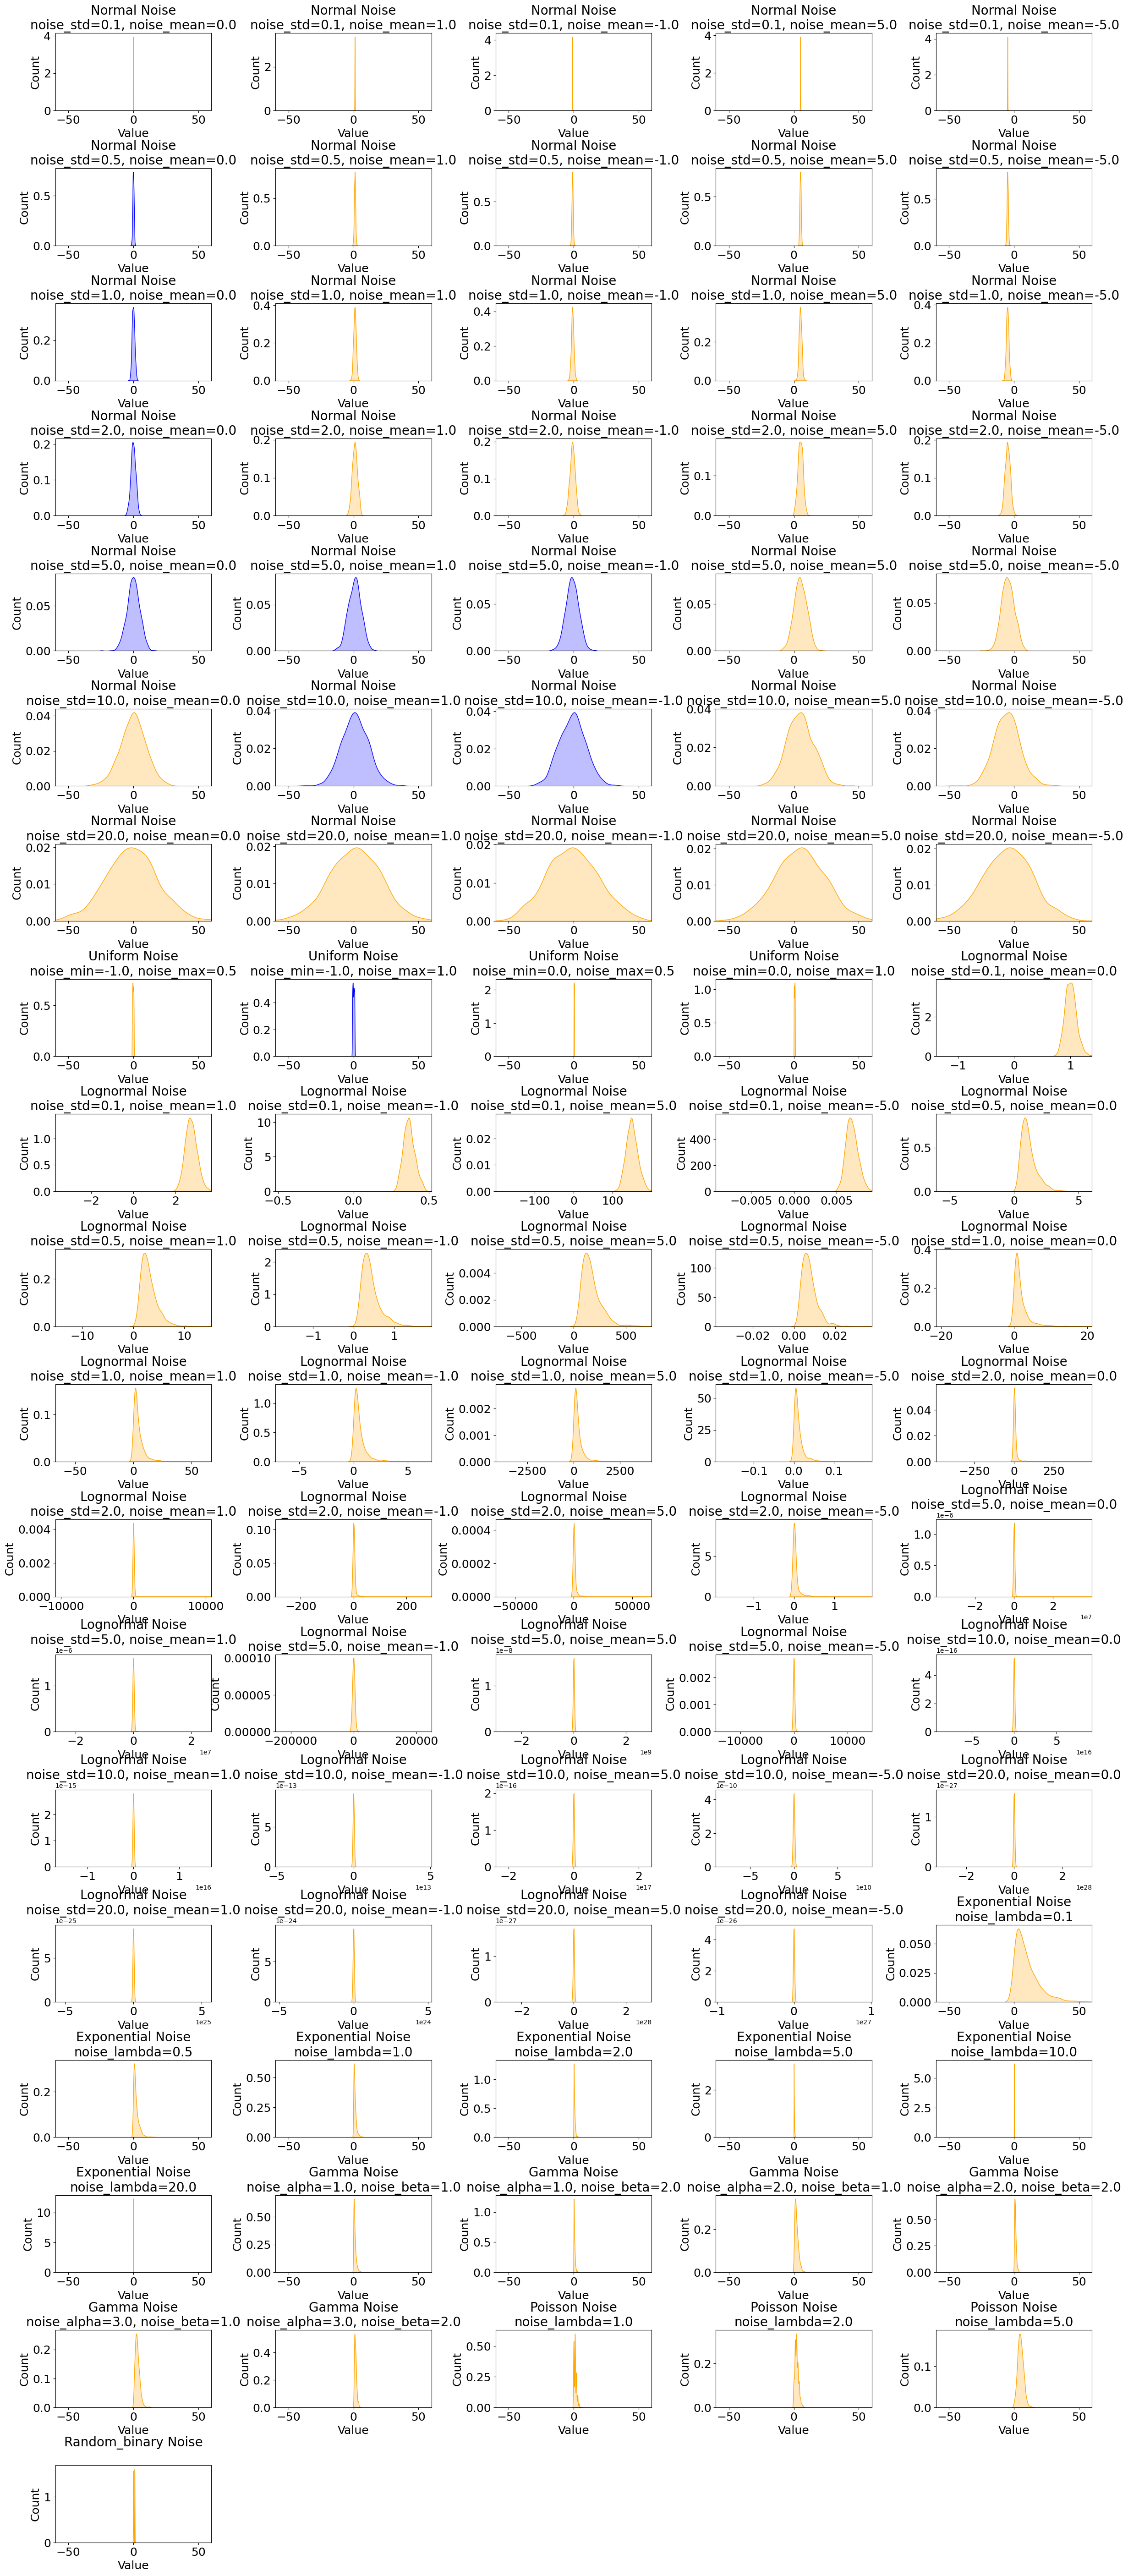

In [138]:
# Parameters for the noise generation
input_size = 1000  # Increased latent size for better visualization
batch_size = 1
device = 'cpu'  # Assuming we are running on CPU for this example



# Define ranges for parameters and ensure they are all lists
noise_params = {
    'normal': {'noise_std': [0.1, 0.5, 1.0, 2.0, 5.0, 10.0, 20.0], 'noise_mean': [0.0, 1.0, -1.0, 5.0, -5.0]},
    'uniform': {'noise_min': [-1.0, 0.0], 'noise_max': [0.5, 1.0]},
    'lognormal': {'noise_std': [0.1, 0.5, 1.0, 2.0, 5.0, 10.0, 20.0], 'noise_mean': [0.0, 1.0, -1.0, 5.0, -5.0]},
    'exponential': {'noise_lambda': [0.1, 0.5, 1.0, 2.0, 5.0, 10.0, 20.0]},
    'gamma': {'noise_alpha': [1.0, 2.0, 3.0], 'noise_beta': [1.0, 2.0]},
    'poisson': {'noise_lambda': [1.0, 2.0, 5.0]},
    'random_binary': {}  # No parameters to vary for random_binary
}

# Helper function to check if a config matches a highlight combination
def is_highlighted(config, noise_type, highlight_combinations):
    for comb in highlight_combinations:
        if comb['noise_type'] == noise_type:
            if all(config.get(k) == comb.get(k) for k in comb if k != 'noise_type'):
                return True
    return False

# Set up for plotting
num_plots = sum(len(list(itertools.product(*params.values()))) if params else 1 for params in noise_params.values())
cols = 5
rows = (num_plots // cols) + (num_plots % cols > 0)  # Calculate the number of rows needed for the grid

fig, axs = plt.subplots(rows, cols, figsize=(25, rows * 3))
axs = axs.flatten()  # Flatten for easier iteration
fig.tight_layout(pad=7.0)


plot_idx = 0

# Generate and plot histograms for each noise type and parameter set
for noise_type, params in noise_params.items():
    if params:
        param_names = list(params.keys())
        param_combinations = list(itertools.product(*params.values()))
    else:
        param_combinations = [()]  # No parameters to vary for random_binary

    for config_tuple in param_combinations:
        config = dict(zip(param_names, config_tuple))
        
        # config['noise_type'] = noise_type
        # config['input_size'] = input_size
        # config['batch_size'] = batch_size
        
        # Merge config with other required parameters (input_size, batch_size) into a single args
        args_dict = {
            'latent_size': input_size,
            'batch_size': batch_size,
            'noise_type': noise_type,
            **config  # Merge the config parameters
        }
        
        # Convert args_dict to argparse.Namespace
        args = argparse.Namespace(**args_dict)


        # Generate noise
        # Create an instance of the NoiseGenerator class
        noise_gen = modules.noise_generator.NoiseGenerator(args, device)
        z = noise_gen.generate_noise()
        z_numpy = z.cpu().numpy().flatten()

        # Determine the color: default blue, special color if highlighted
        color = 'orange'
        if is_highlighted(config, noise_type, highlight_combinations):
            color = 'blue'  # You can change this to any color you want

        # Calculate symmetric x-limits based on the max absolute value of the generated noise
        max_val = max(abs(z_numpy.min()), abs(z_numpy.max()))
        
        y_limits = (0, 1)   # Adjust for appropriate counts (depends on input_size)
        if noise_type != 'lognormal':
            x_limits = (-60, 60)
        else:
            x_limits = (-max_val, max_val)


        # axs[plot_idx].hist(z.cpu().numpy().flatten(), bins=50, range=x_limits, color=color) # Plot histogram 
        sns.kdeplot(z.cpu().numpy().flatten(), ax=axs[plot_idx], fill=True, color=color)  # Plot distribution
        
        config_str = ", ".join(f"{k}={v}" for k, v in config.items())
        
        axs[plot_idx].set_xlim(x_limits)
        # axs[plot_idx].set_ylim(y_limits)
        
        axs[plot_idx].set_title(f"{noise_type.capitalize()} Noise\n{config_str}", fontsize=20)
        axs[plot_idx].set_xlabel('Value', fontsize=18)
        axs[plot_idx].set_ylabel('Count', fontsize=18)
        axs[plot_idx].tick_params(axis='both', which='major', labelsize=18)  # Tick labels font size

        plot_idx += 1

# Hide empty subplots if there are any
for i in range(plot_idx, len(axs)):
    axs[i].axis('off')

plt.show()


In [7]:
pd.set_option("display.max_rows", 100)
filtered_df

,--noise_type,--noise_std,--noise_mean,--noise_min,--noise_max,--noise_alpha,--noise_beta,--noise_lambda,count
0,normal,0.5,0.0,NA,NA,NA,NA,NA,10
1,normal,1.0,0.0,NA,NA,NA,NA,NA,10
2,normal,2.0,0.0,NA,NA,NA,NA,NA,10
3,normal,5.0,0.0,NA,NA,NA,NA,NA,10
4,normal,5.0,1.0,NA,NA,NA,NA,NA,10
5,normal,10.0,1.0,NA,NA,NA,NA,NA,9
6,uniform,NA,NA,-1.0,1.0,NA,NA,NA,9
7,normal,10.0,-1.0,NA,NA,NA,NA,NA,8
8,normal,5.0,-1.0,NA,NA,NA,NA,NA,8
9,normal,10.0,0.0,NA,NA,NA,NA,NA,3


# Results presentation

In [96]:
dataset = 'BAS'
dataset = 'MNIST'

img_dim_='2'

wandb_dir = f'../{dataset}/wandb'
model_dir = f'../{dataset}/models'

start_time = "20240911_163739"
end_time = "20250913_030736"


if dataset == 'BAS':
    run_id = '7dlekoq5'  # BAS 4x4
    run_id = 'ceh4lafi' # BAS 3x3
    run_id = 't32j66oy'  #'k0ednnx8'
elif dataset == 'MNIST':
    run_id = 'iq5uhx4z' # 'l61o81oc'  # MNIST gan-noise-investigation-11
else:
    print("Dataset doesn't exist.")

df = extract_wandb_data(wandb_dir, start_time, end_time)
df.head()  # Display the first few rows of the DataFrame

# print(f"Parameters for every run of {dataset} loaded.")

# Call the function with configurable thresholds
# highlight_combinations, filtered_df = filter_and_extract_noise_params(df, d_x_threshold=0.8, d_gz_threshold=0.2, convergence_count=7, img_dim=img_dim_)

,timestamp,id,Noise Mean,Noise Std,Noise Skewness,Noise Kurtosis,Noise Range,Noise Entropy,Monobit Frequency Test,Block Frequency Test,...,_wandb,--project_wandb,--noise_type,--noise_std,--noise_mean,--noise_alpha,--noise_beta,--noise_lambda,--noise_min,--noise_max
0,2024-09-15 23:40:38,u9ovesdl,0.368981,0.037066,0.231794,0.011892,0.267568,-710.956648,1.0,NaN,...,{'runtime': 1501},gan-noise-investigation-10,lognormal,0.1,-1.0,NaN,NaN,NaN,NaN,NaN
1,2024-09-14 10:55:34,tbu5gtf8,0.011035,0.014249,4.747998,37.085775,0.201247,-1782.186695,1.0,NaN,...,{'runtime': 3433},gan-noise-investigation-4,lognormal,1.0,-5.0,NaN,NaN,NaN,NaN,NaN
2,2024-09-12 21:00:40,rqvypwf4,5.183114,10.068073,-0.024752,0.103477,70.254623,5.285577,1.0,NaN,...,{'runtime': 130},NaN,normal,10.0,5.0,NaN,NaN,NaN,NaN,NaN
3,2024-09-14 00:53:20,fvlxthel,5.115795,5.027834,0.046577,-0.051536,37.914513,7.968917,1.0,NaN,...,{'runtime': 236},gan-noise-investigation-6,normal,5.0,5.0,NaN,NaN,NaN,NaN,NaN
4,2024-09-15 01:53:13,dade2kbb,3.049962,1.767428,1.153877,1.779179,12.999602,14.239630,1.0,NaN,...,{'runtime': 314},gan-noise-investigation-4,gamma,NaN,NaN,3.0,1.0,NaN,NaN,NaN


In [97]:
# Retrieve parameters from the DataFrame
input_size, hidden_size, image_size, hidden_layers_g, hidden_layers_d, reduction_factor = get_run_parameters(run_id, df)

# Instantiate the models with the correct parameters
G = Generator(input_size=input_size, hidden_size=hidden_size, output_size=image_size, hidden_layers=hidden_layers_g, reduction_factor=reduction_factor)
D = Discriminator(input_size=image_size, hidden_size=hidden_size, hidden_layers=hidden_layers_d, reduction_factor=reduction_factor)

# Instantiate models and move to device
# G = Generator(args.latent_size, args.hidden_size, args.image_size, args.hidden_layers_g, args.reduction_factor).to(device)
# D = Discriminator(args.image_size, args.hidden_size, args.hidden_layers_d, args.reduction_factor).to(device)


# Load the saved models from .pth files
discriminator_state_dict, generator_state_dict = load_models_by_id(run_id, model_dir=model_dir)

# Load the state_dict into the models
G.load_state_dict(generator_state_dict)
D.load_state_dict(discriminator_state_dict)

# Set the models to evaluation mode
G.eval()
D.eval()

print("Models loaded and set to evaluation mode with parameters from the DataFrame.")


Models loaded and set to evaluation mode with parameters from the DataFrame.


## Functions for presenting

In [98]:
def plot_noise_raw(noise_type_, config_, z):
    # Prepare to plot
    fig, ax = plt.subplots(figsize=(15, 8))  # Single plot, no need for multiple axes

    # Plot the provided noise data
    ax.plot(z.cpu().numpy().flatten())  # Plotting the flattened noise

    # Create title string from noise type and config
    config_str = ", ".join(f"{k}={v}" for k, v in config_.items())
    ax.set_title(f"{noise_type_.capitalize()} Noise\n{config_str}")
    ax.set_xlabel('Index')
    ax.set_ylabel('Value')

    # Show the plot
    plt.show()

In [99]:
def plot_noise_histogram(z, noise_type, config):
    z_numpy = z.cpu().numpy().flatten()

    # Calculate mean and standard deviation
    mean = np.mean(z_numpy)
    std = np.std(z_numpy)

    # Plot distribution using Kernel Density Estimation (KDE)
    fig, ax = plt.subplots(figsize=(15, 8))  # Single plot, no need for multiple axes
#     sns.kdeplot(z_numpy, fill=True)
    sns.histplot(z_numpy, kde=True)

    # Format the plot title and labels
    config_str = ", ".join(f"{k}={v}" for k, v in config.items())
    ax.set_title(f"{noise_type.capitalize()} Noise\n{config_str}", fontsize=20)
    ax.set_xlabel('Value', fontsize=18)
    ax.set_ylabel('Density', fontsize=18)
    ax.tick_params(axis='both', which='major', labelsize=18)  # Tick labels font size

    # Display mean and standard deviation on the plot
    textstr = f'Mean: {mean:.4f}\nStd: {std:.4f}'
    ax.text(0.95, 0.95, textstr, transform=ax.transAxes,
            fontsize=18, verticalalignment='top', horizontalalignment='right',
            bbox=dict(facecolor='white', alpha=0.5, edgecolor='black'))

    plt.show()

In [116]:
def visualize_noise_as_image(z, index=0, draw_grid=False):
    """
    Visualizes a single noise vector as a grayscale image, with optional grid lines to delimit each pixel.
    
    Parameters:
        z (torch.Tensor): The noise vector to visualize, expected shape (batch_size, input_size).
        index (int): The index of the noise vector in the batch to visualize.
        draw_grid (bool): Whether to draw grid lines around the pixels.
    """
    # Extract the specific noise vector and reshape it into the largest possible square/rectangle
    input_size = len(z[0])  # Length of the input noise vector
    side = int(np.sqrt(input_size))  # Assume the closest square

    # Check if the size is a perfect square
    if side * side != input_size:
        rows, cols = get_closest_factors(input_size)  # Use the closest rectangle
    else:
        rows, cols = side, side

    # Reshape the noise vector into rows and columns
    noise_image = z[index].reshape(rows, cols).cpu().detach().numpy()

    # Display the noise as an image
    plt.figure(figsize=(5, 5))
    plt.imshow(noise_image, cmap='gray', extent=[0, cols, 0, rows])  # Ensure proper extents for grid lines
    plt.title(f"Noise Vector as {rows}x{cols} Image (Index {index})")

    # Add grid lines if requested
    if draw_grid:
        plt.gca().set_xticks(np.arange(0, cols, 1))  # Grid lines for columns
        plt.gca().set_yticks(np.arange(0, rows, 1))  # Grid lines for rows
        plt.gca().grid(True, color='red', linestyle='-', linewidth=1.5)  # Draw the grid lines around each pixel
        plt.gca().tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)  # Hide tick labels
    else:
        plt.axis('off')

    plt.show()

def visualize_all_noise_as_grid(z, draw_grid=False):
    """
    Visualizes all noise vectors in a batch as grayscale images in a grid, with optional pixel grid lines.
    
    Parameters:
        z (torch.Tensor): The batch of noise vectors to visualize, expected shape (batch_size, input_size).
        draw_grid (bool): Whether to draw grid lines around the pixels in each image.
    """
    import math

    batch_size = z.shape[0]
    input_size = z.shape[1]

    # Determine the number of rows and columns for the grid
    grid_cols = int(math.ceil(math.sqrt(batch_size)))  # Closest square grid
    grid_rows = int(math.ceil(batch_size / grid_cols))

    # Compute image dimensions
    side = int(np.sqrt(input_size))
    if side * side != input_size:
        rows, cols = get_closest_factors(input_size)
    else:
        rows, cols = side, side

    # Create the grid of subplots
    fig, axes = plt.subplots(grid_rows, grid_cols, figsize=(grid_cols * 2, grid_rows * 2))
    axes = axes.flatten()  # Flatten the grid for easier indexing

    for i, ax in enumerate(axes):
        if i < batch_size:
            # Reshape the noise vector into rows and columns
            noise_image = z[i].reshape(rows, cols).cpu().detach().numpy()
            ax.imshow(noise_image, cmap='gray', extent=[0, cols, 0, rows])
            ax.set_title(f"Index {i}", fontsize=8)

            # Add grid lines if requested
            if draw_grid:
                ax.set_xticks(np.arange(0, cols, 1))
                ax.set_yticks(np.arange(0, rows, 1))
                ax.grid(True, color='red', linestyle='-', linewidth=0.5)
                ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
            else:
                ax.axis('off')
        else:
            ax.axis('off')  # Hide unused subplots

    # Adjust layout
    plt.tight_layout()
    plt.show()



def get_closest_factors(n):
    """
    Finds the closest factors of n to form a rectangular grid.
    
    Parameters:
        n (int): The number to factor.
    
    Returns:
        tuple: Two integers representing the rows and columns for the grid.
    """
    sqrt_n = int(np.sqrt(n))
    for i in range(sqrt_n, 0, -1):
        if n % i == 0:
            return i, n // i  # Return rows and columns (factors of n)



In [101]:
def visualize_fake_image(z, index=0):
    """
    Visualizes a single noise vector as a 28x28 grayscale image.

    Parameters:
        z (torch.Tensor): The noise vector to visualize, expected shape (batch_size, input_size).
        index (int): The index of the noise vector in the batch to visualize.
    """
    global D, G

    fake_images = G(z)
    outputs = D(fake_images)
    score = outputs.mean().item()

    side = int(np.sqrt(len(fake_images[0])))
    noise_image = fake_images[index].reshape(side, side).cpu().detach().numpy()

    # Display the noise as an image
    plt.figure(figsize=(5, 5))
    plt.imshow(noise_image, cmap='gray')
    plt.title(f"Fake image -> score:{score:.3f}")
    plt.axis('off')
    plt.show()

# Generate noise

In [130]:
noise_params = {
    'normal': {'noise_std': 1, 'noise_mean': 1.0}, 
    # 'uniform': {'noise_max': 10, 'noise_min': -10},
    # 'lognormal': { 'noise_mean': 0.0, 'noise_std': 5.0},
    # 'exponential': {'noise_lambda': 0.1},
    # 'gamma': {'noise_alpha': 1.0, 'noise_beta': 1.0},
    # 'poisson': {'noise_lambda': 3.0},
    # 'random_binary': {}  # No parameters to vary for random_binary
}



for key in noise_params.keys():
   noise_type_ = key
config_ = noise_params[noise_type_]


# Merge config with other required parameters (input_size, batch_size) into a single args
args_dict = {
    'latent_size': input_size,
    'batch_size': 6,
    'noise_type': noise_type_,
    **config_  # Merge the config parameters
}

# Convert args_dict to argparse.Namespace
args = argparse.Namespace(**args_dict)


# Generate noise
# Create an instance of the NoiseGenerator class
noise_gen = modules.noise_generator.NoiseGenerator(args, device)
z = noise_gen.generate_noise()
# z_numpy = z.cpu().numpy().flatten()

# z = generate_noise(2, input_size, noise_type_, config_, True) 

z

tensor([[ 1.7015e+00, -1.4432e+00,  5.9177e-01,  1.4901e+00,  5.3586e-01,
         -8.3417e-01,  2.2011e+00,  6.5027e-01, -2.0403e-01, -4.5089e-01,
          2.1374e+00,  9.2668e-01,  1.6023e+00,  1.2881e+00,  1.0863e+00,
          2.1251e+00,  2.7820e-02,  2.9022e+00,  1.0465e+00,  4.1602e-01,
          9.0251e-01, -8.4605e-01,  1.5000e+00,  1.3940e+00,  9.9494e-01,
          2.4637e+00, -2.4040e-02,  1.9838e-01, -8.8792e-01,  1.9746e+00,
          1.9126e+00,  1.2898e+00,  4.2297e-01,  1.0314e+00,  1.4036e+00,
          1.1647e+00,  2.5507e+00,  3.6973e-01,  7.7993e-01, -3.9459e-01,
          5.6676e-01, -2.0719e-01, -7.3619e-01, -1.4902e+00, -1.0098e-01,
          3.4906e+00,  6.6492e-01, -2.0440e-03,  9.5912e-01,  9.9714e-01,
          1.1513e+00,  6.5616e-01,  5.7702e-01,  6.7967e-01,  1.2763e+00,
          1.3664e+00,  2.8271e+00,  5.0390e-01,  6.8318e-01,  1.7334e+00,
          1.5182e+00,  1.5772e+00,  2.4632e-01, -1.3122e-01],
        [ 1.2985e+00,  1.1598e+00, -1.2853e-01,  1

# Visualize Noise - raw

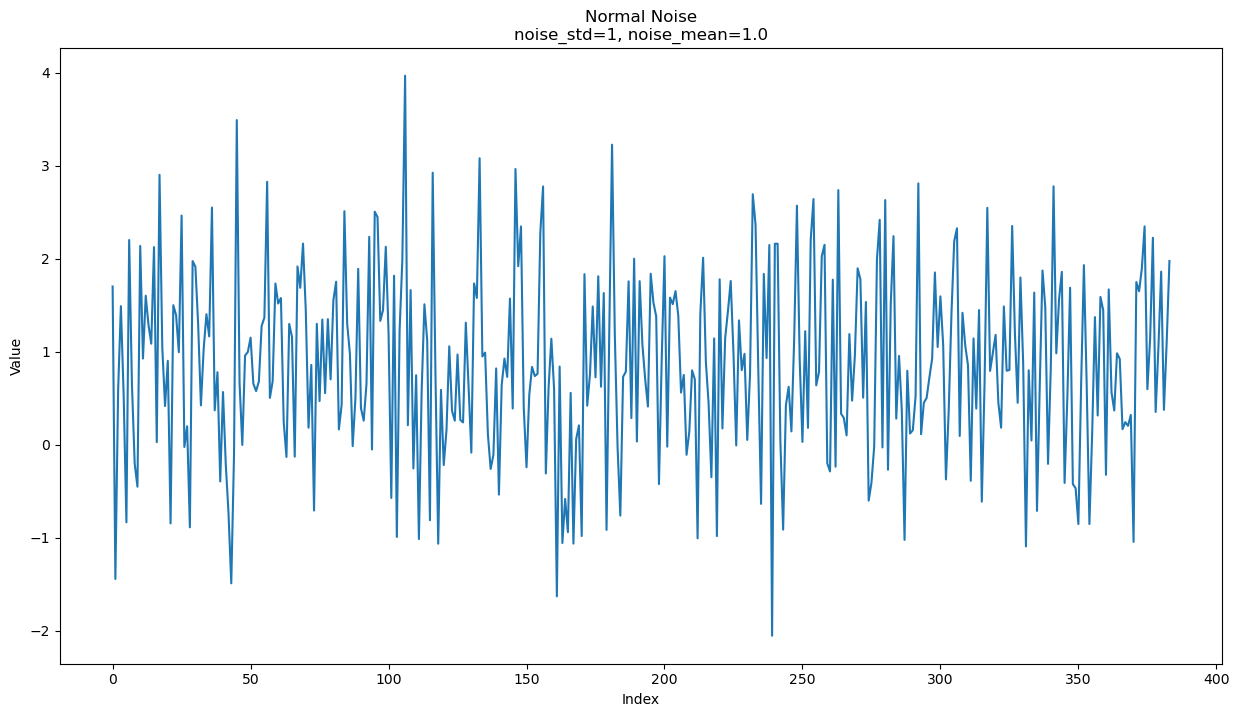

In [131]:
plot_noise_raw(noise_type_, config_, z)

# Visualize noise - distribution

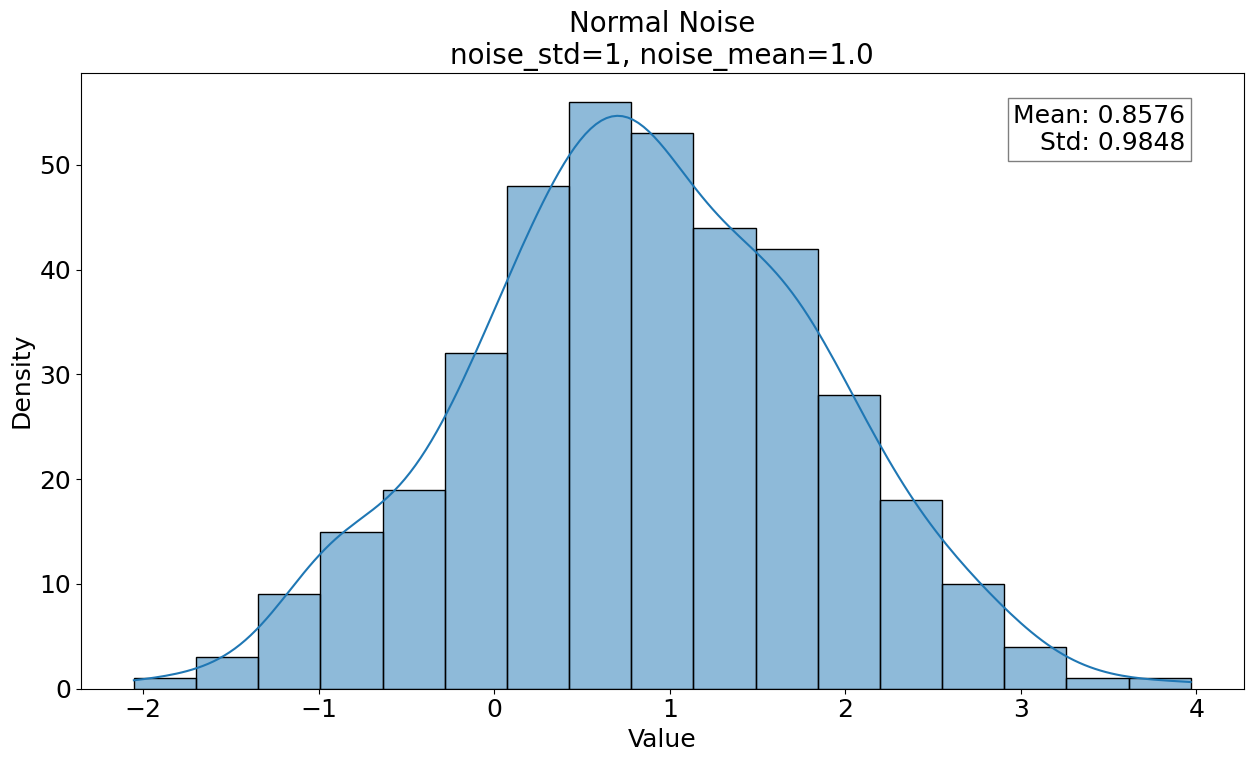

In [132]:
plot_noise_histogram(z, noise_type_, config_, )

# Visualize noise - distribution

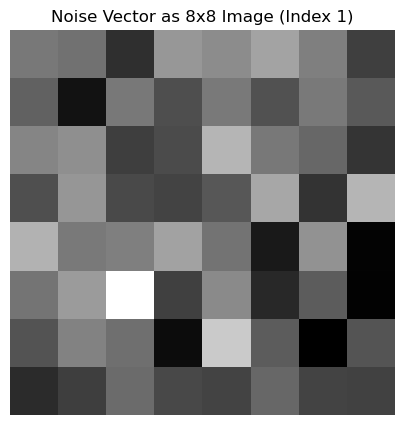

In [133]:
index_ = 1
visualize_noise_as_image(z, index=index_, draw_grid=False)

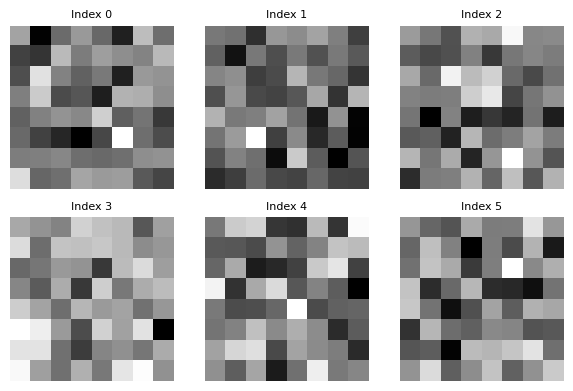

In [134]:
visualize_all_noise_as_grid(z, draw_grid=False)

# Generate image from noise

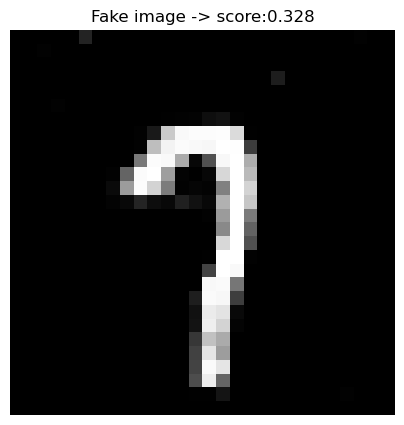

In [135]:
index_ = 0
visualize_fake_image(z, index=index_)

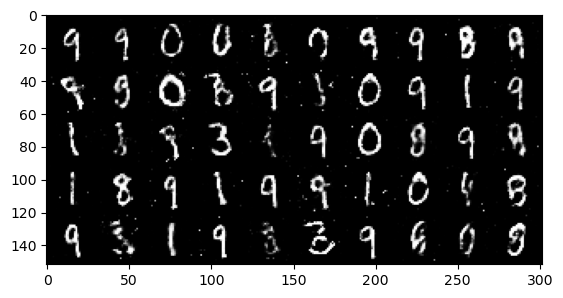

In [136]:
# Merge config with other required parameters (input_size, batch_size) into a single args
args_dict = {
    'latent_size': input_size,
    'batch_size': 50,
    'noise_type': noise_type_,
    **config_  # Merge the config parameters
}

# Convert args_dict to argparse.Namespace
args = argparse.Namespace(**args_dict)


# Generate noise
# Create an instance of the NoiseGenerator class
noise_gen = modules.noise_generator.NoiseGenerator(args, device)
z = noise_gen.generate_noise()

fake_images = G(z)
outputs = D(fake_images)
fake_score = outputs

side = int(np.sqrt(len(fake_images[0])))
# reshaped_images = fake_images[index].reshape(side, side).cpu().detach().numpy()
reshaped_images = fake_images.view(args_dict['batch_size'], 1, side, side)

with torch.no_grad():
    # fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    grid = make_grid(reshaped_images, nrow=10, normalize=True)
    plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
    plt.show()
